In [2]:
from sentence_transformers import SentenceTransformer
import torch
from transformers import (
    AdamW,
    AutoModel,
    get_linear_schedule_with_warmup,
    AutoTokenizer,
    AutoConfig
)

In [3]:
from skt.vault_utils import get_secrets
proxies = get_secrets('proxies')

In [21]:
import os 
import numpy as np
os.environ['http_proxy'] = proxies['http']
os.environ['https_proxy'] = proxies['https']

In [5]:
model = SentenceTransformer('jhlee3421/faq-semantic-klue-roberta-large', device='cuda')

# load data

In [6]:
from skt.gcp import load_bigquery_ipython_magic, \
                    bq_to_pandas, \
                    get_bigquery_client

In [7]:
dataset = 'x1112436'
log_table = 'faq_table'
query = f"""
        SELECT  qry_txt_cont,
                intent_nm,
                ans_cont,
                type
        FROM `skt-datahub.{dataset}.{log_table}`  AS a
        WHERE type = 'faq'
    """

In [8]:
faq_table = bq_to_pandas(query)

unsupported operand type(s) for /: 'NoneType' and 'int'
Downloading: 100%|██████████|


# Save resource

In [9]:
idx2intent_nm = list(faq_table.intent_nm.unique())
intent_nm2idx = {intent_nm : i for i, intent_nm in enumerate(idx2intent_nm)}

In [10]:
idx2query = list(faq_table.qry_txt_cont.unique())
query2idx = {query : i for i, query in enumerate(idx2query)}

In [11]:
black_list_path = '/home/x1112436/faq/blacklist/blacklist.txt'
black_list_sent = set()
with open(black_list_path) as f:
    for data in f:
        line = data.strip()
        black_list_sent.add(line)

# embedding query, intent_nm blacklist

In [14]:
from tqdm.notebook import tqdm

In [12]:
# chunking inetent
def chunking(input_list, chunk_size=200):
    result = []
    chunk_length = int(len(input_list) / chunk_size)
    chunk_rest = len(input_list) % chunk_size

    start = 0
    for i in range(0, chunk_length):
        result.append(input_list[start: start + chunk_size])
        start = start + chunk_size
                      
    if chunk_rest > 0 :
        result.append(input_list[start:])
    return result
        

In [13]:
intent_nm_chunk = chunking(idx2intent_nm)

In [18]:
query_chunk = chunking(idx2query, chunk_size=400)

In [25]:
blacklist_chunk = chunking(list(black_list_sent), chunk_size=400)

In [22]:
def embedding(chunk_list):
    result = []
    for i in tqdm(range(len(chunk_list))):
        if i ==0:
            embedding_result = model.encode(chunk_list[i])
        else:
            embedding = model.encode(chunk_list[i])
            embedding_result = np.concatenate((embedding_result, embedding), axis=0)
        result.extend(chunk_list[i])
    return embedding_result, result

In [23]:
query_embeddings, query_list = embedding(query_chunk)

  0%|          | 0/614 [00:00<?, ?it/s]

In [24]:
intetn_nm_embeddings, intent_nm_list = embedding(intent_nm_chunk)

  0%|          | 0/9 [00:00<?, ?it/s]

In [26]:
blacklist_embeddings, blacklist_list = embedding(blacklist_chunk)

  0%|          | 0/65 [00:00<?, ?it/s]

In [29]:
torch.from_numpy(blacklist_embeddings).shape

torch.Size([25760, 1024])

# save

In [32]:
torch.save(intetn_nm_embeddings, './embedding_result/intent.pkl')
torch.save(query_embeddings, './embedding_result/query.pkl')
torch.save(blacklist_embeddings, './embedding_result/blacklist.pkl')

In [33]:
import pickle
with open('./pickle/intent.pkl', 'wb') as f:
    pickle.dump({
    'idx2intent': idx2intent_nm,
    'intent2idx' : intent_nm2idx
    }, f)
with open('./pickle/query.pkl', 'wb') as f:
    pickle.dump({
    'idx2query': idx2query,
    'query2idx' : query2idx
    }, f)
    
with open('./pickle/blacklist.pkl', 'wb') as f:
    pickle.dump({
    'idx2blacklist': list(black_list_sent),
    }, f)

# TesT

In [37]:
import torch.nn.functional as F

In [38]:
F.normalize(torch.from_numpy(intetn_nm_embeddings), dim=1)

tensor([[ 0.0204,  0.0211, -0.0034,  ...,  0.0211, -0.0504, -0.0035],
        [ 0.0143,  0.0331,  0.0149,  ...,  0.0326, -0.0275, -0.0275],
        [ 0.0002,  0.0333, -0.0062,  ..., -0.0227,  0.0276,  0.0356],
        ...,
        [-0.0537, -0.0461,  0.0309,  ..., -0.0596, -0.0193, -0.0186],
        [-0.0575, -0.0268,  0.0425,  ..., -0.0571, -0.0191, -0.0192],
        [-0.0488, -0.0165,  0.0447,  ..., -0.0553, -0.0216, -0.0079]])

In [60]:
black_list_cosine_sim = F.normalize(torch.from_numpy(blacklist_embeddings), dim=1)@ F.normalize(torch.from_numpy(intetn_nm_embeddings), dim=1).T

In [61]:
values, indices = torch.topk(black_list_cosine_sim, k=1)

In [65]:
import pandas as pd
black_list_pd = pd.DataFrame(values[:, 0].numpy(), columns=['cosine_score'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f832cfaca90>]],
      dtype=object)

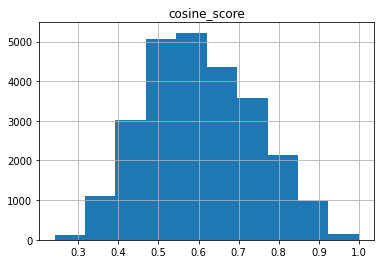

In [67]:
black_list_pd.hist()

In [68]:
query_cosine_sim = F.normalize(torch.from_numpy(query_embeddings), dim=1)@ F.normalize(torch.from_numpy(intetn_nm_embeddings), dim=1).T

In [73]:
q_values, q_indices = torch.topk(query_cosine_sim, k=1)

In [74]:
import pandas as pd
q_list_pd = pd.DataFrame(q_values[:, 0].numpy(), columns=['cosine_score'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f832c5e55e0>]],
      dtype=object)

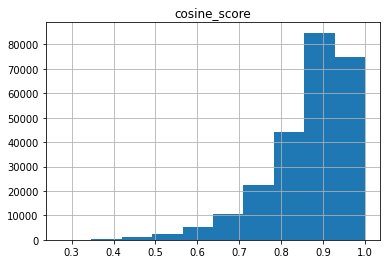

In [75]:
q_list_pd.hist()